In [ ]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.physics.vector.printing import vpprint, vlatex
from sympy.utilities.codegen import codegen
from sympy.utilities.autowrap import autowrap

In [2]:
# initial coordinates

# generalised coordinates
a, b, theta = me.dynamicsymbols('a b theta')

m_w, m_t, x, y, x_f, s_w, s_t, Lambda, c, EI, GJ, g, t, k_theta = sym.symbols('m_w m_t x y x_f s_w s_t Lambda c EI GJ g t k_theta')

q = sym.Matrix([a,b,theta])
qd = q.diff(t)
qdd = qd.diff(t)

In [3]:
# wing z and alpha formulas

z_w = a*y**2+b*(x-x_f)*y
alpha_w = b*y

In [4]:
# wing tip equations

# z_t = z_w.subs(y,s_w) + theta*(y+sym.tan(Lambda)*(x-c/2))
z_t = z_w.subs(y,s_w) + theta*(y)


alpha_t = alpha_w.subs(y,s_w) + theta*sym.sin(Lambda)

## Calculate the Equations of Motion using the Euler Lagrange Equations

$\frac{d}{dt}\frac{\partial L}{\partial \dot{q}} - \frac{\partial L}{\partial q} = 0$

$L = T - U$

### Calculate the Potential Energy

In [5]:
# calculate the potential energy
me.mechanics_printing()
# potential energy stored in main wing from bend and twisting
U = sym.Rational(1,2)*(z_w.diff(y,y)**2*EI).integrate((y,0,s_w))
U = U + sym.Rational(1,2)*(alpha_w.diff(y)**2*GJ).integrate((y,0,s_w))
# potential energy stored in hinge spring
U = U + sym.Rational(1,2)*k_theta*theta**2

# potential energy stored in main wing from gravitational forces
U = U + (z_w*g*m_w).integrate((x,0,c),(y,0,s_w))
U = U + (z_t*g*m_t).integrate((x,0,c),(y,0,s_t))

(z_w*g*m_w).integrate((x,0,c),(y,0,s_w))

In [6]:
U

### Calculate the Potential Energy

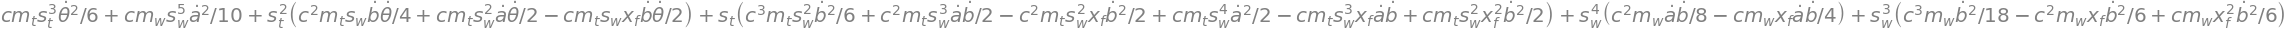

In [7]:
# calculate the kinetic energy
# T = sym.Rational(1,2) * m_w

T = (z_w.diff(t)**2*sym.Rational(1,2)*m_w).integrate((x,0,c),(y,0,s_w))
T = T + (z_t.diff(t)**2*sym.Rational(1,2)*m_t).integrate((x,0,c),(y,0,s_t))
T

### Calculate the Terms on the LHS of the Euler-lagrange equation

In [8]:
# from classic larange equation calulate the first two terms
L = sym.Matrix([T-U])

term_1 = L.jacobian(qd).diff(me.dynamicsymbols._t).T
term_2 = L.jacobian(q).T
LHS = term_1-term_2

#Extract the mass matrix (using the fact highest order term is second derivative)
M = sym.simplify(LHS.jacobian(qdd))

# use the Mass Matrix to find the remainder of the LHS 
K = sym.simplify(LHS - M*qdd).jacobian(q)

#Show m
sym.simplify((LHS - M*qdd) - K*q)
L.jacobian(q)

⎡                                          3                 ⎛ 2              
⎢                           2   c⋅g⋅m_w⋅s_w                  ⎜c ⋅g⋅mₜ⋅s_w     
⎢-4⋅EI⋅s_w⋅a - c⋅g⋅mₜ⋅sₜ⋅s_w  - ────────────  -GJ⋅s_w⋅b - sₜ⋅⎜─────────── - c⋅
⎣                                    3                       ⎝     2          

            ⎞        ⎛ 2                    ⎞             2           ⎤
            ⎟      2 ⎜c ⋅g⋅m_w   c⋅g⋅m_w⋅x_f⎟    c⋅g⋅mₜ⋅sₜ            ⎥
g⋅mₜ⋅s_w⋅x_f⎟ - s_w ⋅⎜──────── - ───────────⎟  - ────────── - kₜₕₑₜₐ⋅θ⎥
            ⎠        ⎝   4            2     ⎠        2                ⎦

In [9]:
# Show K
LHS

⎡                                                                             
⎢                                                                             
⎢                                                              4⋅EI⋅s_w⋅a + c⋅
⎢                                                                             
⎢                                                                             
⎢               ⎛ 2                          ⎞      ⎛ 2                       
⎢             2 ⎜c ⋅mₜ⋅s_w⋅θ̈   c⋅mₜ⋅s_w⋅x_f⋅θ̈⎟      ⎜c ⋅g⋅mₜ⋅s_w            
⎢GJ⋅s_w⋅b + sₜ ⋅⎜─────────── - ──────────────⎟ + sₜ⋅⎜─────────── - c⋅g⋅mₜ⋅s_w⋅
⎢               ⎝     4              2       ⎠      ⎝     2                   
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

### Calculate the RHS of the Euler-Lagrange Equation

In [10]:
### Calculate the RHS of the Lagrangian (forcing functions)

#create new symbols
rho, V, a_g, a_w, a_t, alpha_0, e = sym.symbols('rho V a_g a_w a_t alpha_0 e ')
Malphadot = sym.symbols('M_alphadot')
w_g, kappa, alpha = me.dynamicsymbols('w_g kappa alpha')

extraTerms = sym.Matrix([alpha_0,w_g])

# create dynamic symbol for gust

kappad = kappa.diff(me.dynamicsymbols._t)
alphad = alpha.diff(me.dynamicsymbols._t)

# forces act on flexural axis, so alter z eqns (new unit kappa)
kappa_w = z_w.subs(x,x_f)
kappa_t = z_t.subs(x,x_f)
[kappa_w,kappa_t]

In [11]:
# to simplify expression make a constant of the term in kappa_t
lamda = sym.symbols('lamda')
kappa_t = kappa_t.subs({(x_f-c/2)*sym.tan(Lambda):lamda})
kappa_t

#### Calculate the external forces on the Main Wing

In [12]:
# Calc forces on main wing
dL_w = sym.Rational(1,2)*rho*V**2*c*a_w*(alpha_w + kappa_w.diff(t)/V+alpha_0+w_g/V)
dM_w = sym.Rational(1,2)*rho*V**2*c**2*(e*a_w*(alpha_w + kappa_w.diff(t)/V+alpha_0)+Malphadot*alpha_w.diff(t)*c/(4*V)+w_g/V)

Q = (sym.Matrix([kappa_w]).jacobian(q).T*dL_w).integrate((y,0,s_w))
Q = Q + (sym.Matrix([alpha_w]).jacobian(q).T*dM_w).integrate((y,0,s_w))

# get the B and C matrices
remainder = Q
B_w = Q.jacobian(qd)
remainder = (Q - B_w*qd)
C_w = remainder.jacobian(q)
remainder = remainder - C_w*q
G_w = sym.simplify((Q-B_w*qd) - C_w*q).jacobian(extraTerms)
remainder = remainder - G_w*extraTerms

In [13]:
# Show B
B_w


⎡              5                      ⎤
⎢ V⋅a_w⋅c⋅ρ⋅s_w                       ⎥
⎢ ──────────────           0         0⎥
⎢       10                            ⎥
⎢                                     ⎥
⎢       2        4         3      3   ⎥
⎢V⋅a_w⋅c ⋅e⋅ρ⋅s_w   M_α̇⋅V⋅c ⋅ρ⋅s_w    ⎥
⎢─────────────────  ───────────────  0⎥
⎢        8                 24         ⎥
⎢                                     ⎥
⎣        0                 0         0⎦

In [14]:
# Show C
C_w

⎡     2            4     ⎤
⎢    V ⋅a_w⋅c⋅ρ⋅s_w      ⎥
⎢0   ───────────────    0⎥
⎢           8            ⎥
⎢                        ⎥
⎢    2      2        3   ⎥
⎢   V ⋅a_w⋅c ⋅e⋅ρ⋅s_w    ⎥
⎢0  ──────────────────  0⎥
⎢           6            ⎥
⎢                        ⎥
⎣0          0           0⎦

In [15]:
# Show G
G_w

⎡  2            3                 3⎤
⎢ V ⋅a_w⋅c⋅ρ⋅s_w     V⋅a_w⋅c⋅ρ⋅s_w ⎥
⎢ ───────────────    ──────────────⎥
⎢        6                 6       ⎥
⎢                                  ⎥
⎢ 2      2        2      2      2  ⎥
⎢V ⋅a_w⋅c ⋅e⋅ρ⋅s_w    V⋅c ⋅ρ⋅s_w   ⎥
⎢──────────────────   ───────────  ⎥
⎢        4                 4       ⎥
⎢                                  ⎥
⎣        0                 0       ⎦

#### Calculate external Forces on the wing-tip

In [16]:
# Calc forces on main wing
dL_t = sym.Rational(1,2)*rho*V**2*c*a_t*(alpha_t + kappa_t.diff(t)/V+alpha_0+w_g/V)
dM_t = sym.Rational(1,2)*rho*V**2*c**2*(e*a_t*(alpha_t + kappa_t.diff(t)/V+alpha_0)+Malphadot*alpha_t.diff(t)*c/(4*V)+w_g/V)

Q = (sym.Matrix([kappa_t]).jacobian(q).T*dL_t).integrate((y,0,s_t))
Q = Q + (sym.Matrix([alpha_t]).jacobian(q).T*dM_t).integrate((y,0,s_t))

# get the B and C matrices
remainder = Q
B_t = Q.jacobian(qd)
remainder = (Q - B_t*qd)
C_t = remainder.jacobian(q)
remainder = remainder - C_t*q
G_t = sym.simplify((Q-B_t*qd) - C_t*q).jacobian(extraTerms)
remainder = remainder - G_t*extraTerms

In [17]:
# show B
sym.simplify(B_t)

⎡                         4                                                   
⎢          V⋅aₜ⋅c⋅ρ⋅sₜ⋅s_w                                                    
⎢          ────────────────                       0                           
⎢                 2                                                           
⎢                                                                             
⎢              2           3                     3         2                 2
⎢        V⋅aₜ⋅c ⋅e⋅ρ⋅sₜ⋅s_w               M_α̇⋅V⋅c ⋅ρ⋅sₜ⋅s_w               V⋅c
⎢        ───────────────────              ──────────────────              ────
⎢                 2                               8                           
⎢                                                                             
⎢               2                             3                           ⎛   
⎢V⋅aₜ⋅c⋅ρ⋅sₜ⋅s_w ⋅(2⋅c⋅e⋅sin(Λ) + sₜ)  M_α̇⋅V⋅c ⋅ρ⋅sₜ⋅s_w⋅sin(Λ)  V⋅c⋅ρ⋅sₜ⋅⎝3⋅
⎢────────────────────────────────────  ─────────────

In [18]:
# show C
sym.simplify(C_t)

⎡             2              3                    2              2            
⎢            V ⋅aₜ⋅c⋅ρ⋅sₜ⋅s_w                    V ⋅aₜ⋅c⋅ρ⋅sₜ⋅s_w ⋅sin(Λ)     
⎢0           ─────────────────                   ────────────────────────     
⎢                    2                                      2                 
⎢                                                                             
⎢            2     2           2                 2     2                      
⎢           V ⋅aₜ⋅c ⋅e⋅ρ⋅sₜ⋅s_w                 V ⋅aₜ⋅c ⋅e⋅ρ⋅sₜ⋅s_w⋅sin(Λ)    
⎢0          ────────────────────                ──────────────────────────    
⎢                    2                                      2                 
⎢                                                                             
⎢    2                                     2                                  
⎢   V ⋅aₜ⋅c⋅ρ⋅sₜ⋅s_w⋅(2⋅c⋅e⋅sin(Λ) + sₜ)  V ⋅aₜ⋅c⋅ρ⋅sₜ⋅(2⋅c⋅e⋅sin(Λ) + sₜ)⋅sin
⎢0  ────────────────────────────────────  ──────────

In [19]:
# show G
sym.simplify(G_t)

⎡        2              2                               2       ⎤
⎢       V ⋅aₜ⋅c⋅ρ⋅sₜ⋅s_w                 V⋅aₜ⋅c⋅ρ⋅sₜ⋅s_w        ⎥
⎢       ─────────────────                ────────────────       ⎥
⎢               2                               2               ⎥
⎢                                                               ⎥
⎢       2     2                               2                 ⎥
⎢      V ⋅aₜ⋅c ⋅e⋅ρ⋅sₜ⋅s_w                 V⋅c ⋅ρ⋅sₜ⋅s_w        ⎥
⎢      ───────────────────                 ─────────────        ⎥
⎢               2                                2              ⎥
⎢                                                               ⎥
⎢ 2                                                             ⎥
⎢V ⋅aₜ⋅c⋅ρ⋅sₜ⋅(2⋅c⋅e⋅sin(Λ) + sₜ)  V⋅c⋅ρ⋅sₜ⋅(aₜ⋅sₜ + 2⋅c⋅sin(Λ))⎥
⎢────────────────────────────────  ─────────────────────────────⎥
⎣               4                                4              ⎦

In [20]:
M

⎡           4                                       3                         
⎢      c⋅s_w ⋅(5⋅mₜ⋅sₜ + m_w⋅s_w)              c⋅s_w ⋅(c - 2⋅x_f)⋅(4⋅mₜ⋅sₜ + m
⎢      ──────────────────────────              ───────────────────────────────
⎢                  5                                             8            
⎢                                                                             
⎢     3                                       2                     ⎛ 2       
⎢c⋅s_w ⋅(c - 2⋅x_f)⋅(4⋅mₜ⋅sₜ + m_w⋅s_w)  c⋅s_w ⋅(3⋅mₜ⋅sₜ + m_w⋅s_w)⋅⎝c  - 3⋅c⋅
⎢──────────────────────────────────────  ─────────────────────────────────────
⎢                  8                                             9            
⎢                                                                             
⎢                   2    2                                   2                
⎢            c⋅mₜ⋅sₜ ⋅s_w                             c⋅mₜ⋅sₜ ⋅s_w⋅(c - 2⋅x_f)
⎢            ─────────────                          

In [69]:
M_matrix = sym.MatrixSymbol('M', *M.shape)
K_matrix = sym.MatrixSymbol('K', *M.shape)
Bw_matrix = sym.MatrixSymbol('B_w', *M.shape)
Cw_matrix = sym.MatrixSymbol('C_w', *M.shape)
Gw_matrix = sym.MatrixSymbol('G_w', *M.shape)
Bt_matrix = sym.MatrixSymbol('B_t', *M.shape)
Ct_matrix = sym.MatrixSymbol('C_t', *M.shape)
Gt_matrix = sym.MatrixSymbol('G_t', *M.shape)

M_eq = sym.Eq(M_matrix, M)
K_eq = sym.Eq(K_matrix, K)
Bw_eq = sym.Eq(Bw_matrix, B_w)
Cw_eq = sym.Eq(Cw_matrix, C_w)
Gw_eq = sym.Eq(Gw_matrix, G_w)
Bt_eq = sym.Eq(Bt_matrix, B_t)
Ct_eq = sym.Eq(Ct_matrix, C_t)
Gt_eq = sym.Eq(Gt_matrix, G_t)

In [91]:
Ms = sym.printing.octave_code((M,K),assign_to = ('M','K'))

TypeError: OctaveCodePrinter cannot assign to object of type <class 'tuple'>

In [82]:
G_t

⎡           2              2                                  2       ⎤
⎢          V ⋅aₜ⋅c⋅ρ⋅sₜ⋅s_w                    V⋅aₜ⋅c⋅ρ⋅sₜ⋅s_w        ⎥
⎢          ─────────────────                   ────────────────       ⎥
⎢                  2                                  2               ⎥
⎢                                                                     ⎥
⎢          2     2                                  2                 ⎥
⎢         V ⋅aₜ⋅c ⋅e⋅ρ⋅sₜ⋅s_w                    V⋅c ⋅ρ⋅sₜ⋅s_w        ⎥
⎢         ───────────────────                    ─────────────        ⎥
⎢                  2                                   2              ⎥
⎢                                                                     ⎥
⎢V⋅c⋅ρ⋅sₜ⋅(2⋅V⋅aₜ⋅c⋅e⋅sin(Λ) + V⋅aₜ⋅sₜ)  V⋅c⋅ρ⋅sₜ⋅(aₜ⋅sₜ + 2⋅c⋅sin(Λ))⎥
⎢──────────────────────────────────────  ─────────────────────────────⎥
⎣                  4                                   4              ⎦

In [83]:
f = autowrap((M_eq,K_eq,Bw_eq,Cw_eq,Bt_eq,Ct_eq), backend = 'cython',tempdir ='C:\\Users\\qe19391\\OneDrive - University of Bristol\\Documents\\Projects\\FWTD modelling\\1 - PyDy Equations of Motion\\test', args = [c,s_w,s_t,m_w,m_t,x_f,e,EI,GJ,k_theta,Lambda, Malphadot, V, a_t, a_w, rho])

In [58]:
f(1,10,1,10,1,0.55,0.2,100,100,1)

(array([[4.e+03, 0.e+00, 0.e+00],
        [0.e+00, 1.e+03, 0.e+00],
        [0.e+00, 0.e+00, 1.e+00]]),
 array([[ 2.10000000e+05, -1.30000000e+03,  5.00000000e+01],
        [-1.30000000e+03,  2.94694444e+02, -2.50000000e-01],
        [ 5.00000000e+01, -2.50000000e-01,  3.33333333e-01]]))

In [59]:
sym.cse((M,K,B_w,C_w,G_w,B_t,C_t,G_t))


⎛                                                                             
⎜                                                                             
⎜                                                                             
⎜                                                                             
⎜                                                                             
⎜⎡                            ⎛       4⎞                               ⎛      
⎜⎢(x₀, m_w⋅s_w), (x₁, mₜ⋅sₜ), ⎝x₂, s_w ⎠, (x₃, c⋅x₂), (x₄, c - 2⋅x_f), ⎝x₅, s_
⎜⎣                                                                            
⎜                                                                             
⎜                                                                             
⎜                                                                             
⎝                                                                             

                                                   

In [54]:
B_t

⎡                              4                                              
⎢               V⋅aₜ⋅c⋅ρ⋅sₜ⋅s_w                                               
⎢               ────────────────                            0                 
⎢                      2                                                      
⎢                                                                             
⎢                   2           3                          3         2        
⎢             V⋅aₜ⋅c ⋅e⋅ρ⋅sₜ⋅s_w                    M_α̇⋅V⋅c ⋅ρ⋅sₜ⋅s_w        
⎢             ───────────────────                   ──────────────────        
⎢                      2                                    8                 
⎢                                                                             
⎢      2           2                     2    2         3                     
⎢V⋅aₜ⋅c ⋅e⋅ρ⋅sₜ⋅s_w ⋅sin(Λ)   V⋅aₜ⋅c⋅ρ⋅sₜ ⋅s_w   M_α̇⋅V⋅c ⋅ρ⋅sₜ⋅s_w⋅sin(Λ)  M_
⎢────────────────────────── + ─────────────────  ───